In [1]:
!pip install emcee
!pip install corner

In [3]:
!pip install pymc3

  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529958 sha256=6ca27e3f5ce67bbc63d145db3869b06b92052ec84deff0c8d833a1a7b841d71f
  Stored in directory: c:\users\djjd2\appdata\local\pip\cache\wheels\0e\41\d2\82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc


In [8]:
import numpy as np
import matplotlib.pylab as plt
from numpy import math
from scipy.optimize import curve_fit
import seaborn as sns
from scipy import stats
from scipy.stats import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import emcee
import seaborn as sns
import corner
import pymc3 as pm
import arviz as az

$a_0 = b_0$, $a_1 = b_0b_1$, $a_2 = b_0(b_1^2/2 + b_2)$,$a_3 = −b_0b_3$ y $a_4=b_4$

Hay que tener en cuenta que $b_3$ es la opacidad de la ionosfera, por lo cual debe ser mayor a cero, para que exista absorción y no amplificación.


$\alpha$ para puede ser n valor que oscila entre 2.4 a 2.7

In [11]:
Dat=np.loadtxt('figure1_plotdata.csv',delimiter=',',skiprows=1)
Names=np.array(['Frequency [MHz]', 'Weight', 'a: Tsky [K]', 'b: Tres1 [K]', 'c: Tres2 [K]','d: Tmodel [K]', 'e: T21 [K]'
])

In [12]:
#relaciona entre a_n y b_n
a_0,a_1,a_2,a_3,a_4=1659, 118.51,-904.4,49.50,-124.86 
b0=a_0
b1=a_1/a_0
b2=(a_2/b0-b1*2/2)
b3=-a_3/a_0
b4=a_4
Bow=b0,b1,b2,b3,b4

In [13]:
# los datos de estas constantes estan el kelvin, al igual que los datos tomados de EDGES

Bow= 1590, 660,-1100,690,-165,0.5,78.3,20.75,8.0,0.05             # intersección con el eje y
Pyemcee= -11221.09499241, -14168.57143649, -10203.98895781,    144.62969775,12659.42909717,500.0/1000,78.3,19.0,7.0,0.05   #ajuste coeficientes de minimos cuadrados
Pyemcee2=  1743.9711358801117, 147.55004539601418, -685.8034915470453,  36.53665860684164,-196.18414188062908, 0.524285560037914, 78.6235695471557, 21.162879332114997,7.6124372729808196,0.05
Intento= -14285.22801433, -17568.34439754, -12412.45765732,    167.33842652, 15700.28024181, 0.51948421412718, 78.51820480335225, 19.32741526388625, 7.001176416303,0.05
Natu_result= -10111.419 ,-5673.739 ,-1831.621 ,150.673 ,11711.500 ,0.553, 6.78 ,78.31 ,18.74,0.05
Natu= 2000, -720,1000,-720,175,1.12,78.3,19.5,2.8,0.05 
Col=['b','r','darkorange','darkmagenta','gold','g','khaki','r','indigo','teal']
Cons=np.array([Bow,Pyemcee,Pyemcee2,Intento,Natu_result,Natu])
Cons_names=np.array(['Bow','Pyemcee','Pyemcee2','Natu_result','Intento','Natu'])



### Funciones

In [14]:
"""
Funciones de la temperatura 
Sky
"""
##################################0-
def T_f(v,a0,a1,a2,a3,a4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return a0*(v/vc)**-2.5+a1*(v/vc)**-2.5*np.log10(v/vc)+a3*(v/vc)**-4.5+a4*(v/vc)**-2.0+a2*(v/vc)**-2.5*np.log10(v/vc)**2
def T_21(v,A,v0,w,tau):
  B=((4*(v-v0)**2)/(w**2))*(np.log10((-1/tau)*np.log10((1+(np.e**(-tau)))/2)))
  return-A*(1-(np.e**(-tau*(np.e)**(B))))/(1-(np.e**(-tau)))

def T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau):
  T21= T_21(v,A,v0,w,tau)
  Tf= T_f(v,a0,a1,a2,a3,a4)
  return T21+Tf

def T_fb(v,b0,b1,b2,b3,b4):
  vc=np.median(v) #Frecuancia central
  vc=78.0 # frecuancia central (EDGES) 
  return b0*(v/vc)**(-2.5+b1+b2*np.log(v/vc))*np.e**(-b3*(v/vc)**-2.0)+b4*(v/vc)**(-2.0)


In [16]:
def T_modelo(x,y,yerr,const):
  a0,a1,a2,a3,a4,A,v0,w,tau,sigma= const             # intersección con el eje y
  nll=lambda *args: -log_likelihood(*args) # Construccion de la funcion lamda 
  v=x
  N=len(x) 
  vc=78.0
  #Condiciones iniciales
  In=np.array([a0,a1,a2,a3,a4,A,v0,w,tau]) + 0.1 * np.random.randn(9)
  #Solución
  Sol=minimize(nll,In,args=(x, y, yerr))
  # Extrayendo los valores de los parametros arojados por MlE
  popt = Sol.x
  a0_,a1_,a2_,a3_,a4_,A1,v01,w1,tau1=popt

  return popt
"""
def nwlakers(x,y,yerr,Sol,N,walkers,steps,i):
  pos = Sol+ 10e-2* np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr,i))
  sampler.run_mcmc(pos, steps, progress=True);
  
  #parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return sampler

def log_likelihood(theta,x,y,yerr):
  v=x
  sigma=yerr
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
def log_probability(theta, x, y, yerr,i):
    lp = log_p(theta,i,Cons_names)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
def log_p (theta,i,Cons_names):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta

  if Cons_names[i]== 'Bow':
    if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 22.0 and 4.5 <tau< 13.0: 
      return 0.0
  return -np.inf 
"""

"\ndef nwlakers(x,y,yerr,Sol,N,walkers,steps,i):\n  pos = Sol+ 10e-2* np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios\n  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros \n\n  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr,i))\n  sampler.run_mcmc(pos, steps, progress=True);\n  \n  #parametros\n  \n  #Time_autocorr(sampler,i,Ncons,steps)\n  return sampler\n\ndef log_likelihood(theta,x,y,yerr):\n  v=x\n  sigma=yerr\n  a0,a1,a2,a3,a4,A,v0,w,tau = theta\n  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2\n  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))\ndef log_probability(theta, x, y, yerr,i):\n    lp = log_p(theta,i,Cons_names)\n    if not np.isfinite(lp):\n        return -np.inf\n    return lp + log_likelihood(theta, x, y, yerr)\ndef log_p (theta,i,Cons_names):\n  a0,a1,a2,a3,a4,A,v0,w,tau = theta\n\n  if Cons_names[i]== 'Bow':\n    if 1500.0 < a0 < 1650.0 a

### Función de discrepancia

In [17]:
def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//100 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=0.02
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      plt.xlabel("Observed Discrepancies")
      plt.xlabel("Simulated Discrepancies")

      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

### Datos

In [18]:
x,y=Dat[:,0][Dat[:,2]>0],Dat[:,2][Dat[:,2]>0] # Variables

x_C,y_C=Dat[:,0][Dat[:,0]>60.0] ,Dat[:,2][Dat[:,0]>60.0] # Variables
x_C,y_C=x_C[x_C<94.0],y_C[x_C<94.0]

Constante=np.zeros((6,9))
yerr=0.18


In [19]:
def log_p (theta,i,Cons_names):
  a0,a1,a2,a3,a4,A,v0,w,tau = theta
  if 1200.0 < a0 < 2500.0 and -900.0 < a1 < 600.0 and  -1600.0< a2 <1400.0 and -600.0 <a3 < 195.0 and -170.0 < a4 < -120.0 and 0.00170 < A <1.0 and  62.8< v0 <98.0 and 10.5 <w < 25.0 and 0.5 <tau< 13.0:
  #if 1200 < a0 < 1800.0 and -400.0 < a1 < 600.0 and  -180.0< a2 <800.0 and -600.0 <a3 < 10.0 and -180.0 < a4 < 100.0:
    return 0.0
  return -np.inf 

def log_likelihood(theta,x,y,yerr):
  v=x
  sigma=yerr
  a0,a1,a2,a3,a4,A,v0,w,tau= theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))

def log_probability(theta, x, y, yerr,i):
    lp = log_p(theta,i,Cons_names)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)
    
def nwlakers(x,y,yerr,Sol,N,walkers,steps,i):
  pos = Sol+ 10e-4* np.random.randn(walkers, N)  # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  nwalkers, ndim = pos.shape # 2500 caminos, 9 parametros 

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr,i))
  sampler.run_mcmc(pos, steps, progress=True);
  
  #parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return sampler

### Moelo con a_n y sigma fijo 

In [21]:
steps=65000 #pasos
N= 9 # # número de constantes (en este caso esta el menos 1 ya que los arreglos tienen el parametro sigma )


#Sol=1590, 660, -1100, 690, -165
#Sol=1.590, 0.660, -1.100, 0.690, -0.165
#Sol=1659, 118.51,-904.4,49.50,-124.86 # py encee
#Sol=1743.9711358801117, 147.55004539601418, -685.8034915470453,  36.53665860684164,-196.18414188062908 #pyemcee
#Sol=Bow

Sol=1643.62,260.92,-1185.5,76.93,-138.00,0.2,78.3,20.75,2.5

sampler=nwlakers(x_C,y_C,yerr,Sol,N,500,steps,1)
params=sampler.get_chain(discard=100, thin=1000, flat=True)
popt=np.array(params.mean(axis=0))

100%|██████████████████████████████████████████████████████████████████████████| 65000/65000 [1:23:38<00:00, 12.95it/s]


In [23]:
params=sampler.get_chain(discard=100, thin=100, flat=True)
params.shape

(324500, 9)

Bow


<Figure size 432x288 with 0 Axes>

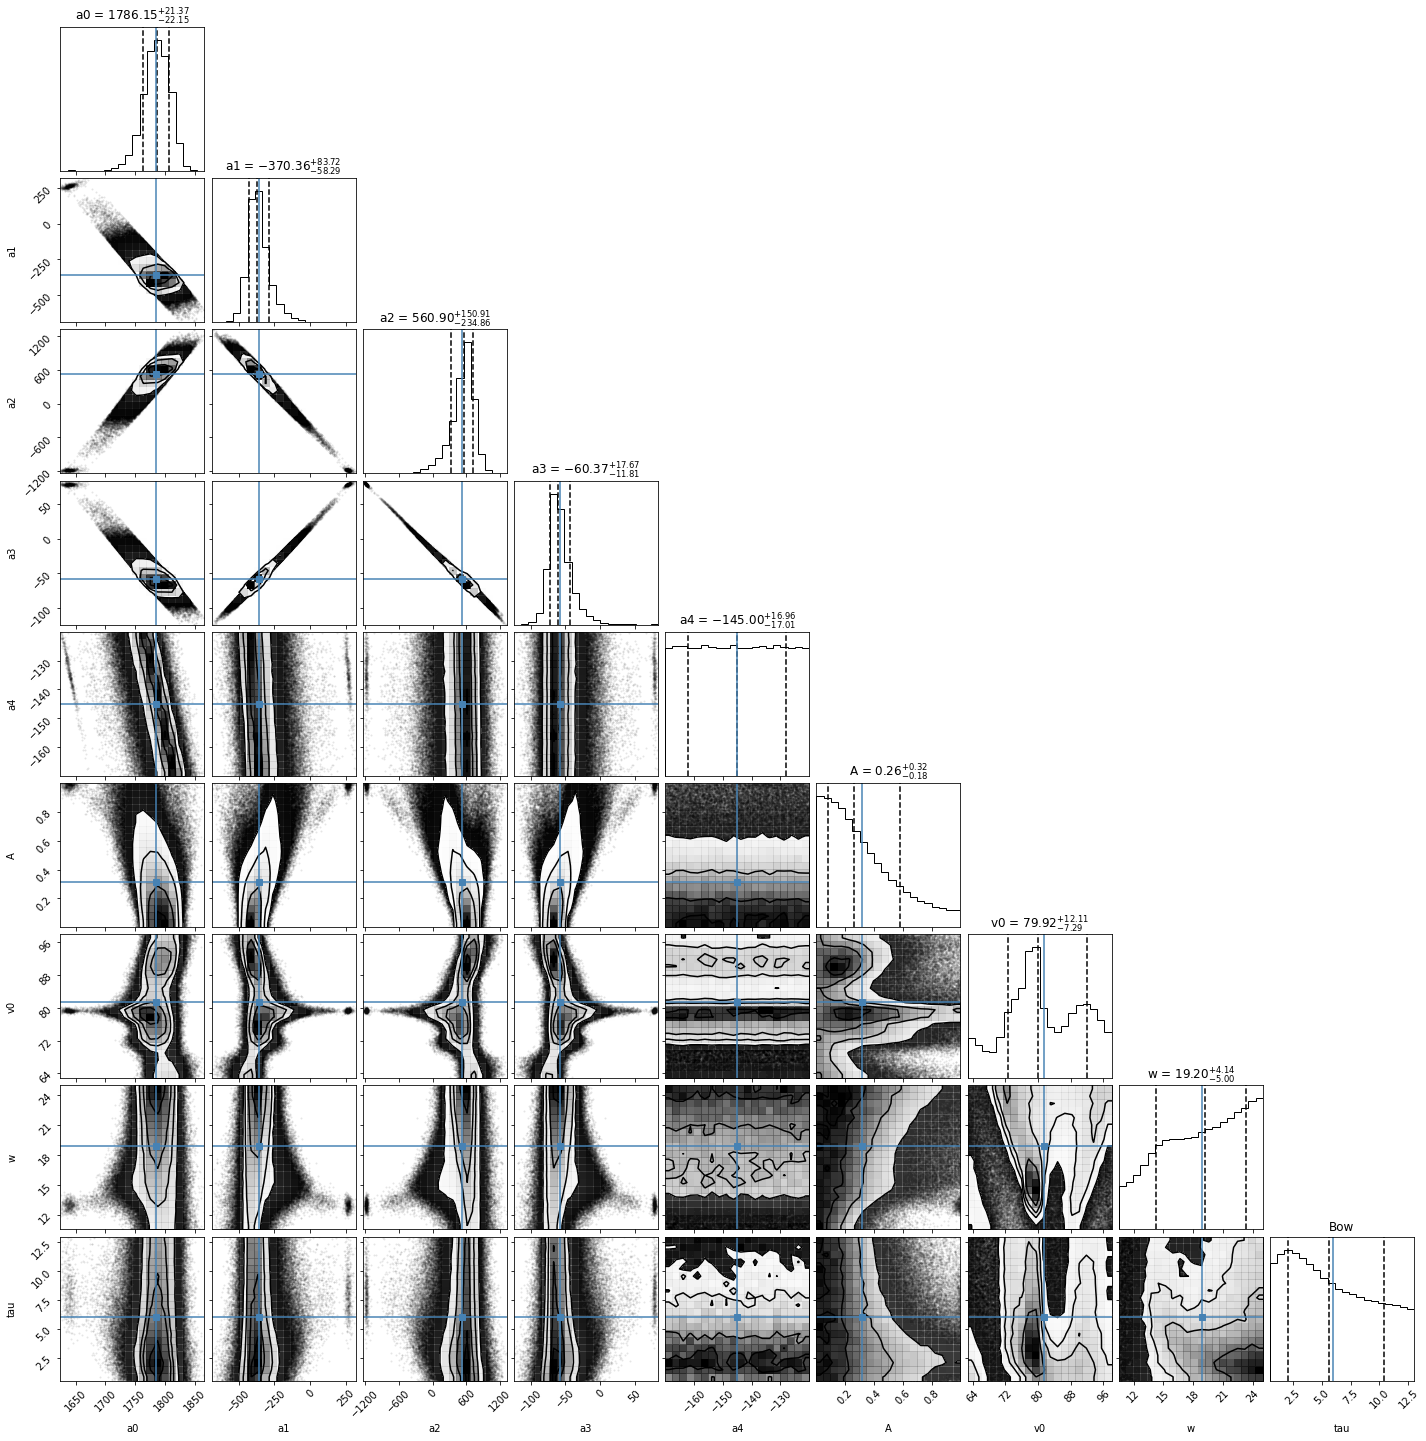

In [25]:
names=np.array(['a0','a1','a2','a3','a4','A','v0','w','tau'])
plt.figure()
for i in range(1):
  print(Cons_names[i])
  corner.corner(params,labels=names,quantiles=[0.16, 0.5, 0.84],truths=popt,show_titles=True)
  plt.title(Cons_names[i]) 
plt.show()

Rejection rate = 0 %
Bayesian p-value: 0.05725731895223421


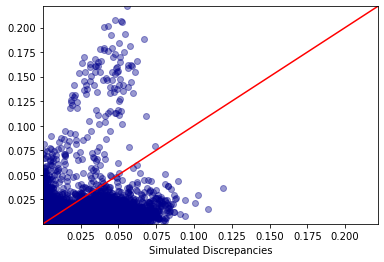

In [26]:
disc(params,x,y)

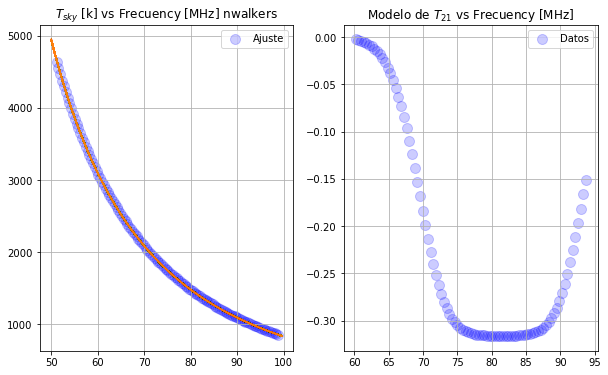

In [30]:
  ii=0
  fig, axs = plt.subplots(1, 2,figsize=(10, 6))
  axs[0].scatter(x,T_sky(x,*popt),color=Col[ii], label='Ajuste',s=100,alpha=0.2)
  for i in range(int(len(params)/1000)):
    axs[0].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  #axs[0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos')
  axs[0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')

  a0,a1,a2,a3,a4,A,v0,w,tau=popt  
  axs[1].scatter(x_C,T_21(x_C,A,v0,w,tau),color='b',alpha=0.2,label='Datos',s=100)
  axs[1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  for ax in axs.flat:
      ax.legend()
      ax.grid()

In [31]:

var_names=names
emcee_data = az.from_emcee(sampler, var_names=var_names)
emcee_data
az.rhat(emcee_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    a0       float64 1.016
    a1       float64 1.022
    a2       float64 1.023
    a3       float64 1.023
    a4       float64 1.009
    A        float64 1.014
    v0       float64 1.03
    w        float64 1.013
    tau      float64 1.01

#priores profesor

# Moldelo $b_n$ Sigma fijo 

In [239]:
Sol=Sol_forz=np.array([1755, -0.08 ,-0.012,0.0052,1100,0.5,78.3,18.9,7.5])# Profe
Sol=Sol_forz=np.array([1750.88, -0.067 ,-0.078,0.00006,394,0.5,78.3,18.6,4.5])
yerr=0.18

In [240]:
def T_f(v,b0,b1,b2,b3,Te):
  vc=75.0 # frecuancia central (rean) 
  return (b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0)+Te*(1-np.exp(-b3*(v/vc)**-2.0))

def log_like(theta,x,y,sigma):
  v=x
  b0,b1,b2,b3,Te,A,v0,w,tau = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,b0,b1,b2,b3,Te,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
def log_prob(theta, x, y):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x, y,0.24)
def log_p(theta):
  b0,b1,b2,b3,Te,A,v0,w,tau = theta
  if 1700 < b0 < 1800.0 and -0.070 < b1 < -0.007 and  -2.1< b2 < -0.00011 and 0.0000 <b3 < 0.2 and 200 < Te < 2000 and 0.170 < A <8.5 and  76.8< v0 <79.0 and 18.5 <w < 22.0 and 4.0 <tau< 10.0:
  #if 1740 < b0 < 1760.0 and -0.1 < b1 < -0.07 and  -0.1< b2 < 0.11 and 0.00010 <b3 < 0.2 and 100 < Te < 1500 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 21.0 and 4.5 <tau< 8.0:
  #if 1700 < b0 < 1760.0 and -0.9 < b1 < 0.07 and  -0.9< b2 < 0.11 and 0.000010 <b3 < 0.2 and 100 < Te < 2000 and 0.170 < A <1.9 and  76.8< v0 <82.0 and 10.5 <w < 25.0 and 0.5 <tau< 10.0:
  #if 1700 < b0 < 1760.0 and -0.1 < b1 < -0.07 and  -0.9< b2 < 0.011 and 0.0010 <b3 < 0.2 and 200 < Te < 2000 and 0.170 < A <1.9 and  76.8< v0 <84.0 and 10.5 <w < 25.0 and 0.5 <tau< 10.0: # Datod del profesor sin modificar
    return 0.0
  return -np.inf

In [241]:

def nwalk_b(x,y,Sol,walkers,steps):
  N=len(Sol)  
  pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-2*(np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  pos=pos.T  
  nwalkers, ndim = pos.shape  

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler#discard=N, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [242]:
steps=80000 #pasos
walkers=500
samples=nwalk_b(x,y,Sol,walkers,steps)

  0%|          | 0/80000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 80000/80000 [1:05:36<00:00, 20.32it/s]


In [243]:
params=samples.get_chain(discard=50, thin=300, flat=True)#parametros

popt=np.array(params.mean(axis=0))

In [244]:
params.shape

(133000, 9)

Bow


<Figure size 432x288 with 0 Axes>

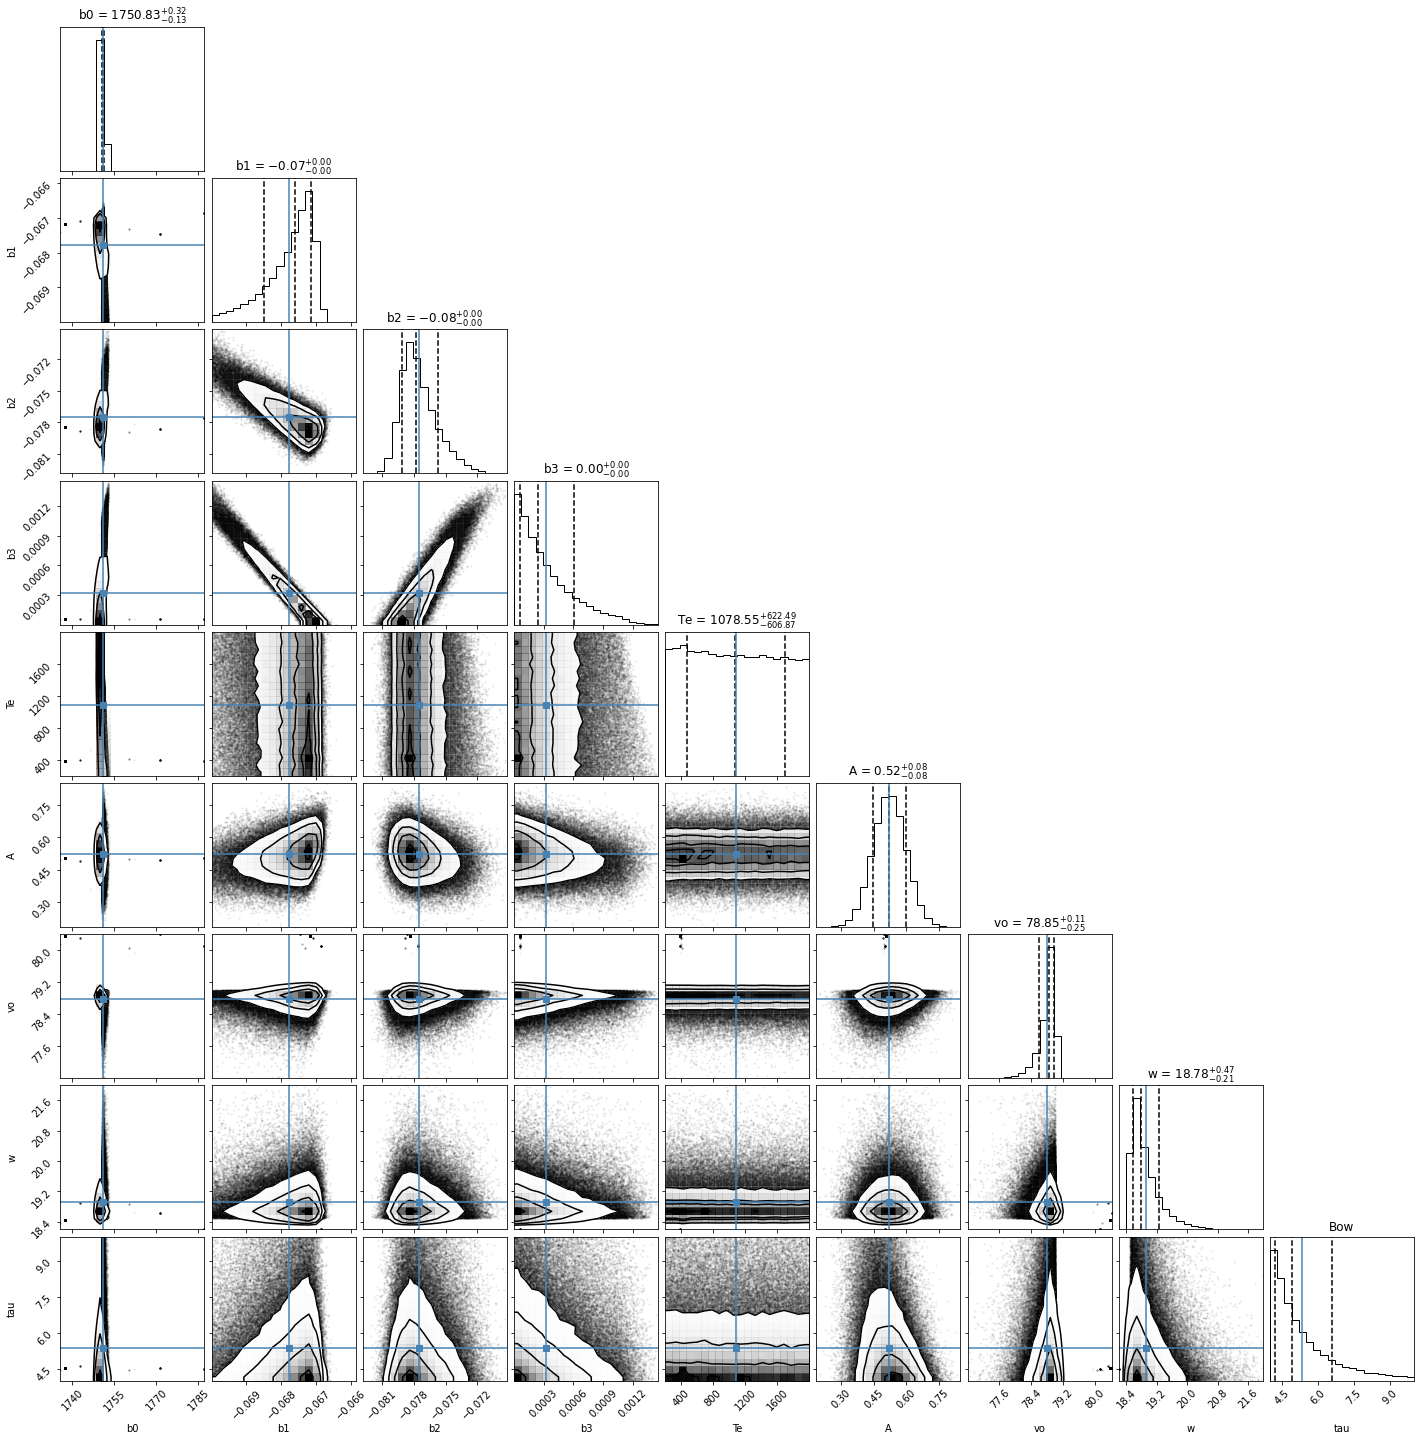

In [245]:
Nlen=1
names=np.array(['b0','b1','b2','b3','Te','A','vo','w','tau'])
plt.figure()
for i in range(Nlen):
  print(Cons_names[i])
  corner.corner(params,labels=names,quantiles=[0.16, 0.5, 0.84],truths=popt,show_titles=True)
  plt.title(Cons_names[i]) 
plt.show()

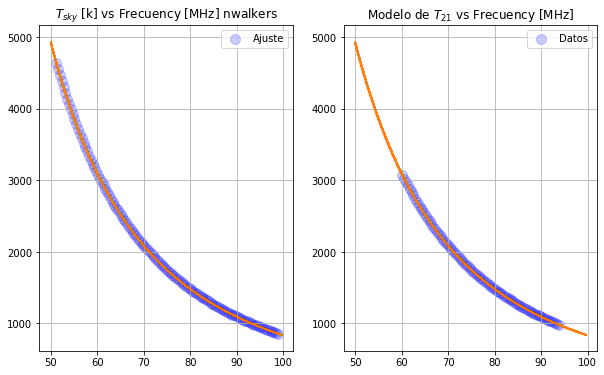

In [236]:
  ii=0
  fig, axs = plt.subplots(1, 2,figsize=(10, 6))
  axs[0].scatter(x,T_sky(x,*popt),color=Col[ii], label='Ajuste',s=100,alpha=0.2)
  for i in range(int(len(params)/1000)):
    axs[0].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  #axs[0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos')
  axs[0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[1].scatter(x_C,y_C,color='b',alpha=0.2,label='Datos',s=100)
  for i in range(int(len(params)/1000)):
    axs[1].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  axs[1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  for ax in axs.flat:
      ax.legend()
      ax.grid()

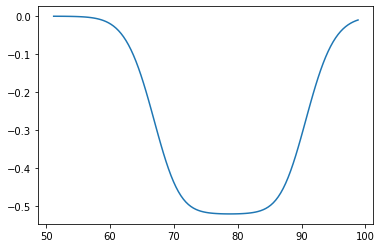

In [253]:
b0,b1,b2,b3,Te,A,v0,w,tau = popt
plt.plot(x,T_21(x, A,v0,w,tau))

In [238]:
sampler=samples
var_names=names
emcee_data = az.from_emcee(sampler, var_names=var_names)
emcee_data
az.rhat(emcee_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b0       float64 1.131
    b1       float64 1.142
    b2       float64 1.133
    b3       float64 1.147
    Te       float64 1.126
    A        float64 1.066
    vo       float64 1.071
    w        float64 1.07
    tau      float64 1.076

In [179]:
def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//1 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=0.18
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      plt.xlabel("Observed Discrepancies")
      plt.xlabel("Simulated Discrepancies")

      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

Rejection rate = 0 %
Bayesian p-value: 0.006581081081081081


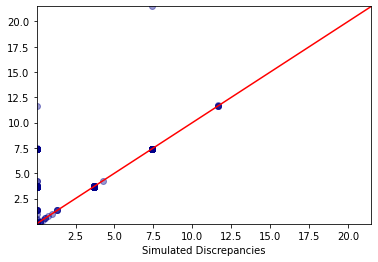

In [180]:
disc(params,x,y)

In [ ]:
params.shape

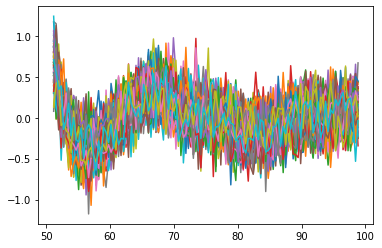

In [247]:
res=[]
for i in range(100):
    selec=np.random.choice(len(params))
    mu=T_sky(x,*params[selec][0:9])
    sig=0.2
    ysim=np.random.normal(mu,sig)
    res+=[y-ysim]
    plt.plot(x,(y-ysim))

# Modelo $b_n$ sigma variable

In [132]:
Sol=Sol_forz=np.array([1755, -0.08 ,-0.012,0.0052,1100,0.5,78.3,18.9,4.5,0.025]) # profe
Sol=Sol_forz=np.array([1750.88, -0.067 ,-0.078,0.00006,394,0.5,78.3,18.6,4.5,0.18])
#yerr=0.025

In [131]:
def T_f(v,b0,b1,b2,b3,Te):
  vc=75.0 # frecuancia central (rean) 
  return (b0*(v/vc)**(-2.5+b1+b2*np.log10(v/vc)))*np.exp(-b3*(v/vc)**-2.0)+Te*(1-np.exp(-b3*(v/vc)**-2.0))

def log_like(theta,x,y):
  v=x
  b0,b1,b2,b3,Te,A,v0,w,tau,sigma = theta
  sn2=sigma**2 #+T_sky(v,a0,a1,a2,a3,a4,A,v0,w,tau)**2
  return -0.5*sum((y-T_sky(v,b0,b1,b2,b3,Te,A,v0,w,tau))**2/sn2 + np.log(2*np.pi*sn2))
def log_prob(theta, x, y):
    lp = log_p(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_like(theta, x, y)
def log_p(theta):
  b0,b1,b2,b3,Te,A,v0,w,tau,sigma = theta
#  if 1500.0 < a0 < 1650.0 and 400.0 < a1 < 900.0 and  -1600.0< a2 <-600.0 and 450.0 <a3 < 950.0 and -225.0 < a4 < -100.0:
  #if 1700 < b0 < 1760.0 and -0.9 < b1 < 0.07 and  -0.9< b2 < 0.11 and -0.10 <b3 < 0.2  and 100 < Te < 2000 and 0.370 < A <0.670 and  77.8< v0 <78.8 and 19.5 <w < 21.0 and 4.5 <tau< 8.0:
  #if 1740 < b0 < 1760.0 and -0.9 < b1 < 0.07 and  -0.9< b2 < 0.11 and -0.10 <b3 < 0.2 and 100 < Te < 2000 and 0.170 < A <1.9 and  76.8< v0 <82.0 and 10.5 <w < 25.0 and 0.5 <tau< 10.0 and 0.002 < sigma <0.9:
  if 1700 < b0 < 1800.0 and -0.070 < b1 < -0.007 and  -2.1< b2 < -0.00011 and 0.0000 <b3 < 0.2 and 200 < Te < 2000 and 0.170 < A <8.5 and  76.8< v0 <79.0 and 18.5 <w < 22.0 and 4.0 <tau< 10.0 and 0.02 < sigma <0.92:
    return 0.0
  return -np.inf

In [133]:

def nwalk_b(x,y,Sol,walkers,steps):
  N=len(Sol)  
  pos = np.array(Sol)[:,np.newaxis]+ np.array(Sol)[:,np.newaxis]*1e-2*(np.random.randn(walkers, N) ).T # posterior ,randn genera 9 arreglos de 1500 n umeros aleatorios
  pos=pos.T  
  nwalkers, ndim = pos.shape  

  sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y))
  sampler.run_mcmc(pos, steps, progress=True);
  
  params=sampler#discard=N, thin=1000, flat=True)#parametros
  
  #Time_autocorr(sampler,i,Ncons,steps)
  return params

In [138]:
steps=60000 #pasos
walkers=500
samples=nwalk_b(x,y,Sol,walkers,steps)

  0%|          | 0/60000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 60000/60000 [49:17<00:00, 20.29it/s]


In [160]:
params=samples.get_chain(discard=100, thin=100, flat=True)#parametros
popt=np.array(params.mean(axis=0))
params.shape

(299500, 10)

Bow


<Figure size 432x288 with 0 Axes>

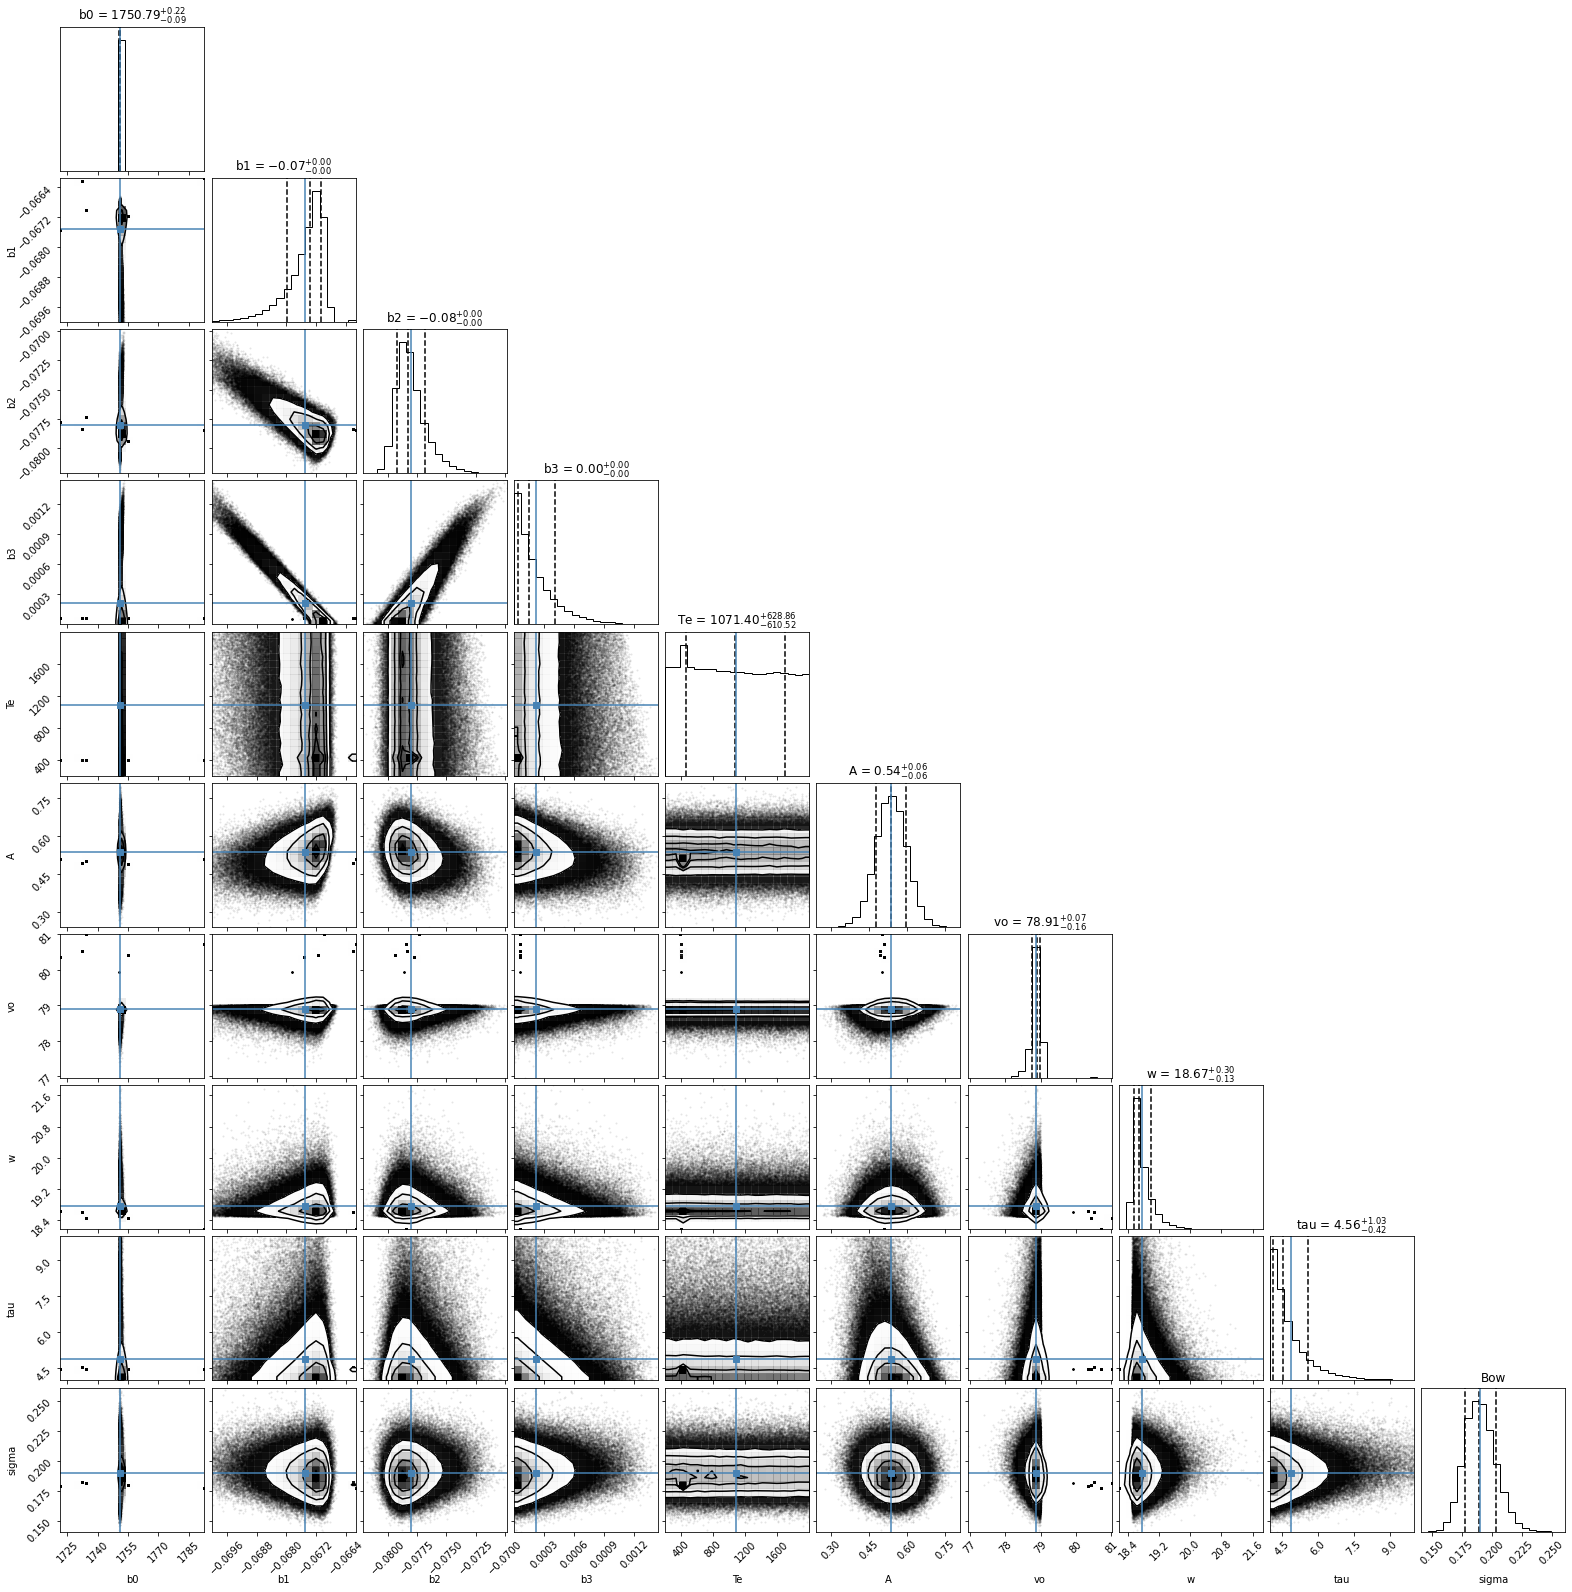

In [161]:
Nlen=1
names=np.array(['b0','b1','b2','b3','Te','A','vo','w','tau','sigma'])
plt.figure()
for i in range(Nlen):
  print(Cons_names[i])
  corner.corner(params,labels=names,quantiles=[0.16, 0.5, 0.84],truths=popt,show_titles=True)
  plt.title(Cons_names[i]) 
plt.show()

In [143]:
sampler=samples
var_names=names
emcee_data = az.from_emcee(sampler, var_names=var_names)
emcee_data
az.rhat(emcee_data)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    b0       float64 1.06
    b1       float64 1.036
    b2       float64 1.017
    b3       float64 1.018
    Te       float64 1.021
    A        float64 1.01
    vo       float64 1.046
    w        float64 1.034
    tau      float64 1.022
    sigma    float64 1.011

In [163]:
def disc(params,x,y):
    rej=0  
    discs=[] 
    disco=[]
    n_100=len(params)//100 # Candtidad de elementos a selecionar del nwalkers
    for i in range(n_100):
        selec=np.random.choice(len(params))
        mu=T_sky(x,*params[selec][:9])
        sig=abs(np.mean(params[:,9]))
        ysim=np.random.normal(mu,sig) # synthetic data
        selex=np.random.choice(len(params))
        yexp=T_sky(x,*params[selex][:9]) # expected values
        if np.any(yexp<0)|np.any(ysim<0):
            rej+=1 # this checks if a negative ysim is generated
        else:        
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()] # se guardan los valores de la discrepacia simulada (Freeman-Tukey)
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()] # Se guadan los valores de la discrepacia observada (Freeman-Tukey)
    print("Rejection rate =",100*rej//n_100,"%") #fraccion de veces que un número negativo fue generado
    if 100*rej//n_100 < 100:
      discs=np.array(discs)
      disco=np.array(disco)
    #      discs_[ii]=discs
    #      disco_[ii]=disco
      # make the discrepancy plot
      plt.scatter(disco,discs,color='darkblue',alpha=0.4,label="Bayesian p-value:"+str(np.round((disco<discs).sum()*1./len(disco),2)))
      dmax=np.max(np.hstack((disco,discs)))
      dmin=np.min(np.hstack((disco,discs)))
      ppp=np.linspace(0,dmax+10,2)
      plt.plot(ppp,ppp,c='r')
      plt.xlim(dmin,dmax)
      plt.ylim(dmin,dmax)
      plt.xlabel("Observed Discrepancies")
      plt.xlabel("Simulated Discrepancies")

      # the Bayesian "p-value" is the fraction of discrepancy realizations 
      # when the observed discrepancy is lower than the simulated discrepancy
      # ideally this "p-value" should not be close to 0 or 1
      print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

Rejection rate = 0 %
Bayesian p-value: 0.993322203672788


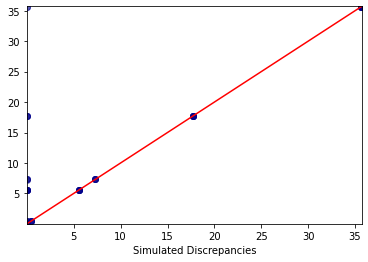

In [164]:
disc(params,x,y)

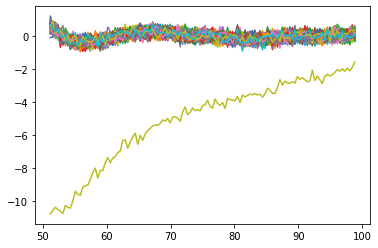

In [162]:
res=[]
for i in range(100):
    selec=np.random.choice(len(params))
    mu=T_sky(x,*params[selec][0:9])
    sig=0.2
    ysim=np.random.normal(mu,sig)
    res+=[y-ysim]
    plt.plot(x,(y-ysim))

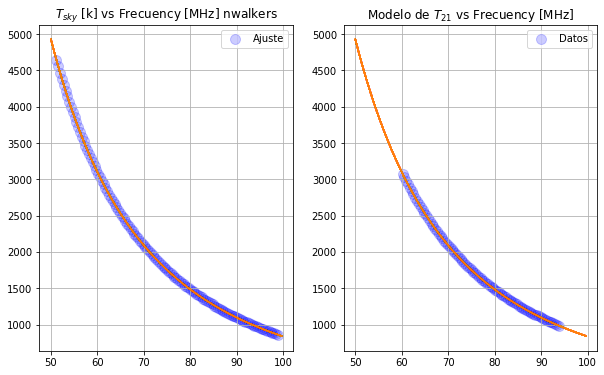

In [152]:
  params=params[:,0:9]
  popt=np.array(params.mean(axis=0))
  
  ii=0
  fig, axs = plt.subplots(1, 2,figsize=(10, 6))
  axs[0].scatter(x,T_sky(x,*popt),color=Col[ii], label='Ajuste',s=100,alpha=0.2)
  for i in range(int(len(params)/1000)):
    axs[0].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  #axs[0].scatter(x_C,y_C,color='black',alpha=0.4,label='Datos')
  axs[0].set_title(r'$T_{sky}$ [k] vs Frecuency [MHz] nwalkers')


  axs[1].scatter(x_C,y_C,color='b',alpha=0.2,label='Datos',s=100)
  for i in range(int(len(params)/1000)):
    axs[1].plot(Dat[:,0],T_sky(Dat[:,0],*params[i]), "C1", alpha=0.1)
  axs[1].set_title(r'Modelo de $T_{21}$ vs Frecuency [MHz]')

  for ax in axs.flat:
      ax.legend()
      ax.grid()

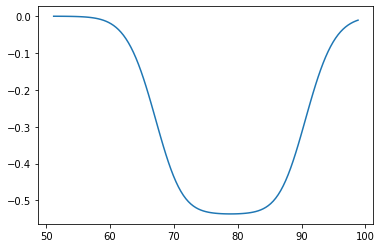

In [153]:
b0,b1,b2,b3,Te,A,v0,w,tau = popt
plt.plot(x,T_21(x, A,v0,w,tau))